In [130]:
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt

## BinaryClassification

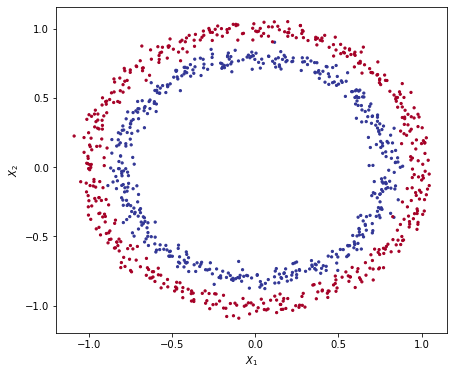

In [131]:
# create classification data
from sklearn.datasets import make_circles

n_samples = 1000
X, y = make_circles(n_samples, noise=0.04, random_state=42)

plt.figure(figsize=(7,6))
plt.scatter(X[:,0], X[:,1], c=y, s=5, cmap=plt.cm.RdYlBu)
plt.xlabel('$X_1$')
plt.ylabel('$X_2$');

In [132]:
X.shape, y.shape

((1000, 2), (1000,))

before training we must change to torch tensor

In [133]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7482,  0.2391],
         [-0.7451,  0.1610],
         [-0.8226,  0.1976],
         [-0.4114,  0.6826],
         [ 0.4439, -0.8958]]),
 tensor([1., 1., 1., 1., 0.]))

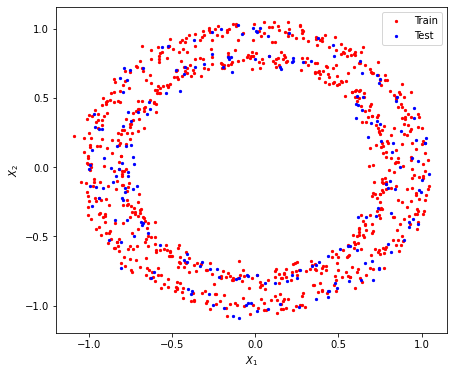

In [134]:
# split the data
np.random.seed(42)
train_size = int(0.8 * len(X))
random_index = np.random.permutation(len(X))
X_train, y_train = X[random_index[:train_size]], y[random_index[:train_size]]
X_test, y_test = X[random_index[train_size:]], y[random_index[train_size:]]

plt.figure(figsize=(7,6))
plt.scatter(X_train[:,0], X_train[:,1], c='red', s=5, label='Train')
plt.scatter(X_test[:,0], X_test[:,1], c='blue', s=5, label='Test')
plt.legend()
plt.xlabel('$X_1$')
plt.ylabel('$X_2$');

In [135]:
# building the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class CircleModel(nn.Module) :
    def __init__(self) :
        super().__init__() 
        # each layer recept the output from previous layer
        self.linear_1 = nn.Linear(in_features=2, out_features=10)
        self.linear_2 = nn.Linear(in_features=10, out_features=10)
        self.linear_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # handle with non-linear data
        self.sigmoid = nn.Sigmoid() # output layer for binary classificaiton

    def forward(self, x) :
        # put the RELU activation between each layer
        return self.sigmoid(self.linear_3(self.relu(self.linear_2(self.relu(self.linear_1(x))))))

model_v1 = CircleModel().to(device)
model_v1

CircleModel(
  (linear_1): Linear(in_features=2, out_features=10, bias=True)
  (linear_2): Linear(in_features=10, out_features=10, bias=True)
  (linear_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [136]:
# setup Loss and Optimizer
loss_fn = nn.BCELoss() # Binary Cross Entropy loss
optimizer = torch.optim.SGD(model_v1.parameters(), lr=0.2)

# accuracy function
def accuracy_fn(y_true, y_pred) :
    correct = torch.eq(y_true, y_pred).sum().item() # eq = equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [137]:
# train the model
torch.manual_seed(42)
epochs = 1000

# put all data on the same device as the model
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs) :

    model_v1.train()
    y_logits = model_v1(X_train).squeeze()
    y_pred = torch.round(y_logits) # 0 or 1

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)
    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

    model_v1.eval()
    with torch.inference_mode() :
        test_logits = model_v1(X_test).squeeze()
        test_pred = torch.round(test_logits) # 0 or 1

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69306, Accuracy: 49.50% | Test Loss: 0.69278, Test Accuracy: 52.00%
Epoch: 100 | Loss: 0.68962, Accuracy: 52.00% | Test Loss: 0.69048, Test Accuracy: 51.50%
Epoch: 200 | Loss: 0.68493, Accuracy: 56.12% | Test Loss: 0.68577, Test Accuracy: 52.50%
Epoch: 300 | Loss: 0.67537, Accuracy: 56.50% | Test Loss: 0.67395, Test Accuracy: 58.50%
Epoch: 400 | Loss: 0.65106, Accuracy: 67.38% | Test Loss: 0.64610, Test Accuracy: 69.50%
Epoch: 500 | Loss: 0.56825, Accuracy: 85.50% | Test Loss: 0.56464, Test Accuracy: 88.00%
Epoch: 600 | Loss: 0.38550, Accuracy: 95.50% | Test Loss: 0.37997, Test Accuracy: 95.50%
Epoch: 700 | Loss: 0.65396, Accuracy: 58.75% | Test Loss: 0.58187, Test Accuracy: 60.50%
Epoch: 800 | Loss: 0.28184, Accuracy: 87.25% | Test Loss: 0.31753, Test Accuracy: 82.00%
Epoch: 900 | Loss: 0.09127, Accuracy: 99.38% | Test Loss: 0.08292, Test Accuracy: 100.00%


In [138]:
# predictions
model_v1.eval()
with torch.inference_mode() :
    y_preds_train = torch.round(model_v1(X_train)).squeeze()
    y_preds_test = torch.round(model_v1(X_test)).squeeze()

y_preds_test[:10], y_test[:10]

(tensor([0., 1., 0., 1., 1., 1., 0., 1., 0., 0.]),
 tensor([0., 1., 0., 1., 1., 1., 0., 1., 0., 0.]))

In [160]:
def plot_decistion_bounary(model, resolution, X, y) :
    x_min, x_max = X[:,0].min()-0.1, X[:,1].max()+0.1
    y_min, y_max = X[:,0].min()-0.1, X[:,1].max()+0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution), np.linspace(y_min, y_max, resolution))

    x_new = np.c_[xx.ravel(), yy.ravel()]
    x_new = torch.from_numpy(x_new).type(torch.float)

    model.eval()
    with torch.inference_mode() :
        y_preds = model(x_new) # prediction
    
    y_preds = torch.reshape(y_preds, (xx.shape))

    plt.contourf(xx, yy, y_preds, alpha=0.5, cmap=plt.cm.RdYlBu)
    plt.scatter(X[:,0], X[:,1], c=y, s=5, cmap=plt.cm.RdYlBu)
    plt.xlabel('$X1$')
    plt.ylabel('$X2$')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

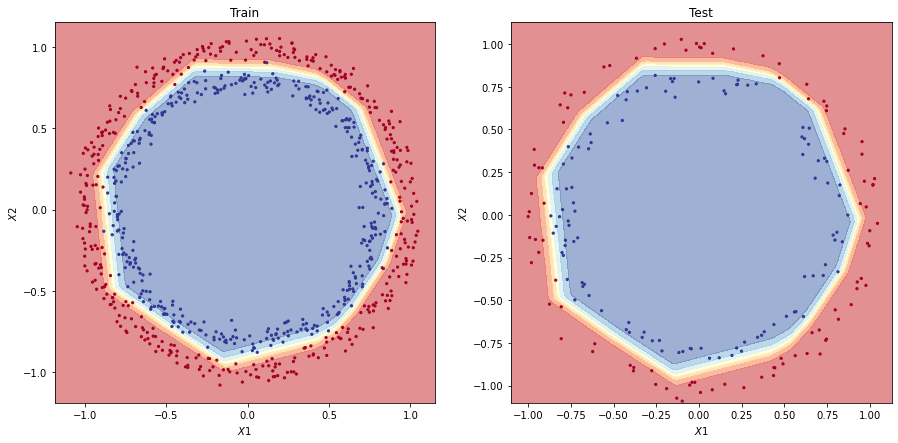

In [163]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plot_decistion_bounary(model_v1, 100, X_train, y_train)
plt.title('Train')

plt.subplot(1,2,2)
plot_decistion_bounary(model_v1, 100, X_test, y_test)
plt.title('Test');

## MultiClassification

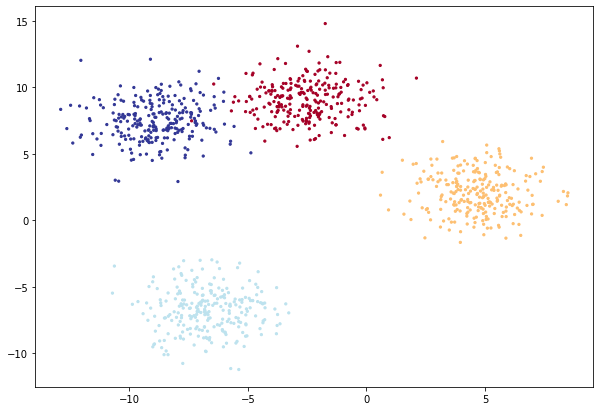

In [168]:
# create data
from sklearn.datasets import make_blobs

n_samples = 1000
num_classes = 4
num_features = 2
X, y = make_blobs(n_samples, n_features = num_features, centers = num_classes, cluster_std=1.5, random_state=42)

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# split the data
np.random.seed(42)
train_size = int(0.8 * len(X))
random_index = np.random.permutation(len(X))
X_train, y_train = X[random_index[:train_size]], y[random_index[:train_size]]
X_test, y_test = X[random_index[train_size:]], y[random_index[train_size:]]

plt.figure(figsize=(10,7))
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu, s=5);